# Spikformer: When Spiking Neural Network Meets Transformer

This notebook provides the simple implementation of Spikformer. It is based on the following sources:

* **Paper**: Zhou, Zhaokun, et al. "[Spikformer: When spiking neural network meets transformer.](https://arxiv.org/abs/2209.15425)" arXiv preprint arXiv:2209.15425 (2022).
* **Source Code**: [ZK-Zhou/spikformer (Github)](https://github.com/ZK-Zhou/spikformer) repository

If you're not familiar with Spiking Neural Networks (SNNs) and snnTorch, please refer to the [snnTorch Tutorials](https://snntorch.readthedocs.io/en/latest/tutorials/index.html) before beginning this notebook.

## Introduction

This paper introduces a novel framework, *Spikformer*, which integrates Spiking Neural Networks (SNNs) with Transformer architectures. It consists of two key components:

* **Spiking Self-Attention (SSA)**: leverages spike-based Query, Key, and Value representations without using softmax.
* **Spiking Patch Splitting (SPS)**: converts input images into spike-form feature patches using convolutional layers followed by spiking neurons.

This design ensures computational efficiency and low energy consumption. The Spikformer outperforms state-of-the-art SNN frameworks in image classification tasks on both static and neuromorphic datasets. For instance, it achieves 74.81% top-1 accuracy on ImageNet with only four time steps.

At the foremost, import required packages:

In [ ]:
!pip install snntorch

In [1]:
import matplotlib.pyplot as plt
import snntorch as snn
import torch
import torch.nn as nn
import torch.optim as optim
from snntorch import surrogate, utils
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

## DataLoading

For the sake of simplicity, we will train the Spikformer on the MNIST dataset.

In [2]:
batch_size = 128
data_path='data/mnist'

Create dataloaders:

In [3]:
C = 1
H = 28
W = 28

# Define a transform
transform = transforms.Compose([
            transforms.Resize((H, W)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

## Spikformer Implementation

Let's define two common variables to train our SNN:

In [4]:
BETA = 0.9 # membrane potential decay rate
SPIKE_GRAD = surrogate.fast_sigmoid() # surrogate gradient function

### Spiking Self-Attention (SSA)

The **Spiking Self-Attention (SSA)** mechanism is the core innovation of the Spikformer architecture, designed to adapt the self-attention mechanism of Transformers for use in Spiking Neural Networks (SNNs). It achieves this by replacing traditional softmax-based attention mechanisms with a biologically plausible, spike-friendly approach. Below is a detailed breakdown of SSA:

1. **Spike-form Query ($Q$), Key ($K$), and Value ($V$)**: These are computed using spike-based linear transformations, ensuring compatibility with the binary and sparse nature of spiking data.
2. **Attention Calculation**: SSA avoids the computationally expensive softmax operation and instead computes attention weights using simple matrix multiplication.

Vanilla self-attention (VSA) requires the softmax function to compute the attention map, which involves exponential calculations and division operations, making it unsuitable for SNNs. In contrast, SSA leverages the naturally non-negative (0 or 1) spike sequences $Q$ and $K$, resulting in a non-negative attention map. This eliminates the need for softmax to ensure non-negativity. The figure below illustrates the intuitive calculation of VSA and SSA:

![](img/spikformer/vsa-ssa.png)

Let’s delve into the details of SSA. Given an input feature sequence $X \in \mathbb{R}^{T \times N \times D}$, the spike-form $Q$, $K$, and $V$ are computed using different spiking neuron layers as follows:

$$
Q = \mathcal{SN}_Q (\text{BN}(XW_Q)), \quad K = \mathcal{SN}_K (\text{BN}(XW_K)), \quad V = \mathcal{SN}_V (\text{BN}(XW_V))
$$

Here, $W_Q$, $W_K$, and $W_V$ are the learnable weight matrices for the query, key, and value projections, respectively. $\mathcal{SN}$ represents the spiking neuron layer, and $\text{BN}$ denotes the batch normalization layer. The output of SSA is computed using simple matrix multiplication:

$$
\begin{align*}
&\text{SSA}'(Q, K, V) = \mathcal{SN} (Q K^\top V * s), \\
&\text{SSA}(Q, K, V) = \mathcal{SN}(\text{BN}(\text{Linear}(\text{SSA}'(Q, K, V)))).
\end{align*}
$$

Here, $s$ is a scaling factor used to control the magnitude of the matrix multiplication result, typically set to $0.125$. The above description of SSA is a single-head version. This single-head SSA can be easily extended to a multi-head SSA, similar to the one used in the original Transformer architecture. The visual representation of the SSA module highlighted in the red box can be seen in the figure below:

![](img/spikformer/ssa.png)

Now, let's implement the SSA module. We will use Leaky Integrate-and-Fire (LIF) neurons for the spiking neuron layer, which is defined as the `snnTorch.Leaky` class in the snnTorch library. For simplicity, we will not consider time steps $T$ during the initial implementation. At the end of the `Spikformer` network, we will loop over the time steps $T$ to compute the final output.

In [5]:
class SSA(nn.Module):
    """Spiking Self-Attention (SSA)"""
    def __init__(self, dim, num_heads=8) -> None:
        super().__init__()
        assert dim % num_heads == 0, f"dim {dim} should be divided by num_heads {num_heads}."
        
        self.dim = dim
        self.num_heads = num_heads
        self.scale = 0.125 # scaling factor to control the large value of the matrix multiplication
        
        self.q_linear = nn.Linear(dim, dim)
        self.q_bn = nn.BatchNorm1d(dim) 
        self.q_lif = snn.Leaky(beta=BETA, spike_grad=SPIKE_GRAD, init_hidden=True) 
        
        self.k_linear = nn.Linear(dim, dim)
        self.k_bn = nn.BatchNorm1d(dim)
        self.k_lif = snn.Leaky(beta=BETA, spike_grad=SPIKE_GRAD, init_hidden=True)
        
        self.v_linear = nn.Linear(dim, dim)
        self.v_bn = nn.BatchNorm1d(dim)
        self.v_lif = snn.Leaky(beta=BETA, spike_grad=SPIKE_GRAD, init_hidden=True)
        
        self.attn_lif = snn.Leaky(beta=BETA, threshold=0.5, spike_grad=SPIKE_GRAD, init_hidden=True)
        
        self.proj_linear = nn.Linear(dim, dim)
        self.proj_bn = nn.BatchNorm1d(dim)
        self.proj_lif = snn.Leaky(beta=BETA, spike_grad=SPIKE_GRAD, init_hidden=True)
        
    def forward(self, x):
        B, N, D = x.shape

        # Calculate spike-form Q, K, V
        q = self.q_linear(x) # linear transformation
        q = self.q_bn(q.transpose(-1, -2)).transpose(-1, -2) # batch normalization
        q = self.q_lif(q) # spiking neuron
        q = q.reshape(B, N, self.num_heads, D // self.num_heads).transpose(1, 2) # (B, num_heads, N, D // num_heads)
        
        v = self.v_linear(x)
        v = self.v_bn(v.transpose(-1, -2)).transpose(-1, -2)
        v = self.v_lif(v)
        v = v.reshape(B, N, self.num_heads, D // self.num_heads).transpose(1, 2)
        
        k = self.k_linear(x)
        k = self.k_bn(k.transpose(-1, -2)).transpose(-1, -2)
        k = self.k_lif(k)
        k = k.reshape(B, N, self.num_heads, D // self.num_heads).transpose(1, 2)
        
        # Calculate spiking multi-head self-attention via matrix multiplication
        attn_score = (q @ k.transpose(-2, -1)) * self.scale # (B, num_heads, N, N)
        ssa = attn_score @ v # (B, num_heads, N, D // num_heads)
        ssa = ssa.transpose(1, 2).reshape(B, N, D) # (B, N, D)
        ssa = self.attn_lif(ssa)
        
        # Project the output
        ssa = self.proj_linear(ssa)
        ssa = self.proj_bn(ssa.transpose(-1, -2)).transpose(-1, -2)
        ssa = self.proj_lif(ssa)
        return ssa

### Spikformer Encoder Block

The next step is to define the Spikformer encoder block. The encoder block consists of two main components:

1. **Spiking Self-Attention (SSA)**: computes the attention scores and generates the output based on the input feature sequence.
2. **Multi-Layer Perceptron (MLP)**: processes the output from the SSA module to produce the final output of the encoder block.
3. **Residual Connection**: applied in both the SSA and MLP block, ensuring that the original information is preserved.

Specifically, given an input feature sequence $X_0 \in \mathbb{R}^{T \times N \times D}$, the output of the $L$-block Spikformer encoder is computed as follows:

$$
\begin{aligned}
& X_l' = \text{SSA}(X_{l-1}) + X_{l-1}, \quad & X_l' &\in \mathbb{R}^{T \times N \times D}, l = 1 \dots L \\
& X_l = \text{MLP}(X_l') + X_l', \quad      & X_l  &\in \mathbb{R}^{T \times N \times D}, l = 1 \dots L
\end{aligned}
$$

The visual representation of the Spikformer encoder block is shown below:

![](img/spikformer/spikformer-encoder-block.png)

Now, let's implement the MLP:

In [6]:
class MLP(nn.Module):
    """Multi-layer Perceptron"""
    def __init__(self, in_features, hidden_features=None, out_features=None) -> None:
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        
        self.fc1_linear = nn.Linear(in_features, hidden_features)
        self.fc1_bn = nn.BatchNorm1d(hidden_features)
        self.fc1_lif = snn.Leaky(beta=BETA, spike_grad=SPIKE_GRAD, init_hidden=True)
        
        self.fc2_linear = nn.Linear(hidden_features, out_features)
        self.fc2_bn = nn.BatchNorm1d(out_features)
        self.fc2_lif = snn.Leaky(beta=BETA, spike_grad=SPIKE_GRAD, init_hidden=True)
        
        self.hidden_dim = hidden_features
        self.out_dim = out_features
        
    def forward(self, x):
        # x: (B, N, D)
        x = self.fc1_linear(x)
        x = self.fc1_bn(x.transpose(-1, -2)).transpose(-1, -2)
        x = self.fc1_lif(x)
        
        x = self.fc2_linear(x)
        x = self.fc2_bn(x.transpose(-1, -2)).transpose(-1, -2)
        x = self.fc2_lif(x)
        return x

and then, implement the Spikformer encoder block:

In [7]:
class SpikformerEncoderBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4.0) -> None:
        super().__init__()
        self.attn = SSA(dim, num_heads=num_heads)
        
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = MLP(in_features=dim, hidden_features=mlp_hidden_dim)
        
    def forward(self, x):
        # residual connection is used
        x = x + self.attn(x)
        x = x + self.mlp(x)
        return x

### Spiking Patch Splitting

The **Spiking Patch Splitting (SPS)** module linearly projects an image into a $D$-dimensional spike-form feature vector and splits it into a sequence of $N$ flattened spike-form patches $x$. Similar to the convolutional stem in Vision Transformer (ViT), a convolution layer in each SPS block is used to introduce inductive bias into Spikformer. Specifically, given an image sequence $I \in \mathbb{R}^{T \times C \times H \times W}$, the SPS is defined as:

$$
x = \mathcal{MP}(\mathcal{SN}(\text{BN}(\text{Conv2d}(I))))
$$

where $\text{Conv2d}$ and $\mathcal{MP}$ represent the 2D convolution layer (stride-1, 3 × 3 kernel size) and max-pooling, respectively. The number of SPS blocks can be more than one. When using multiple SPS blocks, the number of output channels in these convolution layers is gradually increased and eventually matches the embedding dimension of the patches. A 2D max-pooling layer is applied to down-sample the feature size after each SPS block with a fixed size. After processing through the SPS, $I$ is split into an image patch sequence $x \in \mathbb{R}^{T \times N \times D}$.

Additionally, positional embedding is added to the input feature sequence $x$ to retain the spatial information of the image. Floating-point positional embeddings, such as sinusoidal positional embeddings, are not suitable for SNNs. Therefore, the authors employ a conditional positional embedding generator (Chu et al., 2021) to generate spike-form relative positional embeddings (RPE) and add the RPE to the patch sequence $x$ to obtain $X_0$. The conditional positional embedding generator consists of a 2D convolution layer ($\text{Conv2d}$) with a kernel size of 3, batch normalization ($\text{BN}$), and a spiking neuron layer ($\mathcal{SN}$). Formally, the SPS with RPE is defined as:

$$
\begin{aligned}
&x = \text{SPS}(I), \quad & I \in \mathbb{R}^{T \times C \times H \times W}, x \in \mathbb{R}^{T \times N \times D} \\
&\text{RPE} = \mathcal{SN}(\text{BN}(\text{Conv2d}(x))), \quad & \text{RPE}(x) \in \mathbb{R}^{T \times N \times D} \\
&X_0 = x + \text{RPE}, \quad & X_0 \in \mathbb{R}^{T \times N \times D}
\end{aligned}
$$

The visual representation of the SPS module is shown below:

![](img/spikformer/sps.png)

Now, let's implement the SPS module. We will use a four-block SPS (the first two blocks do not contain the max-pooling layer) to split a $28 \times 28$ MNIST image into $49$ $4 \times 4$ patches. This design choice is inspired by the CIFAR-10 experiment in the paper. Additionally, we will implement the SPS with RPE as the `SPS` class and perform the $X_0 = x + \text{RPE}$ operation at the image level (i.e., without flattening into $N$ patches) for simplicity.

In [8]:
class SPS(nn.Module):
    """4 x 4 Spiking Patch Splitting (SPS)"""
    def __init__(self, in_channels, embed_dim=256) -> None:
        super().__init__()
        
        self.conv = nn.Conv2d(in_channels, embed_dim // 8, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(embed_dim // 8)
        self.lif = snn.Leaky(beta=BETA, spike_grad=SPIKE_GRAD, init_hidden=True)
        
        self.conv1 = nn.Conv2d(embed_dim // 8, embed_dim // 4, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(embed_dim // 4)
        self.lif1 = snn.Leaky(beta=BETA, spike_grad=SPIKE_GRAD, init_hidden=True)
        
        # Two times downsampling
        self.conv2 = nn.Conv2d(embed_dim // 4, embed_dim // 2, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(embed_dim // 2)
        self.lif2 = snn.Leaky(beta=BETA, spike_grad=SPIKE_GRAD, init_hidden=True)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        
        # Two times downsampling
        self.conv3 = nn.Conv2d(embed_dim // 2, embed_dim, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(embed_dim)
        self.lif3 = snn.Leaky(beta=BETA, spike_grad=SPIKE_GRAD, init_hidden=True)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        
        self.rpe_conv = nn.Conv2d(embed_dim, embed_dim, kernel_size=3, stride=1, padding=1, bias=False)
        self.rpe_bn = nn.BatchNorm2d(embed_dim)
        self.rpe_lif = snn.Leaky(beta=BETA, spike_grad=SPIKE_GRAD, init_hidden=True)
        
    def forward(self, x):
        # x: (B, C, H, W)
        # Convolutional layers for inductive bias
        x = self.conv(x)
        x = self.bn(x)
        x = self.lif(x)
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.lif1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.lif2(x)
        x = self.maxpool2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.lif3(x)
        x = self.maxpool3(x)
        
        # Relative position embedding
        rpe = self.rpe_conv(x)
        rpe = self.rpe_bn(rpe)
        rpe = self.rpe_lif(rpe)
        x = x + rpe
        
        # Split into an image patches sequence
        x = x.flatten(-2).transpose(-2, -1) # (B, N, D)
        return x

### Spikformer

Finally, we can implement the Spikformer model. The Spikformer model consists of the following components:

1. **Spiking Patch Splitting (SPS)**: converts the input image into a sequence of spike-form patches.
2. **Spikformer Encoder Blocks**: a series of $L$ stacked Spikformer encoder blocks, each containing SSA and MLP components.
3. **Classification Head**: a linear layer that maps the output of the last encoder block to the final classification output.

First of all, the `Spikformer` model takes as input an image batch `image_batch` of shape `(B, C, H, W)`. To integrate membrane potentials and generate spikes in spiking neuron layers, our `Spikformer` model iterates the forward pass of SPS followed by $L$-block Spikformer encoder over $T$ time steps. For each time step, a global average-pooling (GAP) is utilized on the output of the last encoder block to obtain the $D$-dimensional feature vector. Finally, the stacked feature vectors over $T$ time steps are averaged to pass through the classification head.

In [9]:
class Spikformer(nn.Module):
    def __init__(self, c, num_classes, embed_dim=256, num_heads=8, mlp_ratio=4.0, num_blocks=4, num_steps=4) -> None:
        super().__init__()
        self.num_steps = num_steps # T
        
        self.sps = SPS(c, embed_dim=embed_dim)
        self.spikformer_encoder_blocks = nn.ModuleList([
            SpikformerEncoderBlock(embed_dim, num_heads, mlp_ratio) for _ in range(num_blocks)
        ])
        
        self.classification_head = nn.Linear(embed_dim, num_classes)
    
    def forward(self, image_batch):
        # x: (B, C, H, W)
        x_rec = [] # record x over time steps
        
        # reset/initialize hidden states for all LIF neurons in net
        utils.reset(self.sps) 
        utils.reset(self.spikformer_encoder_blocks)
        
        for step in range(self.num_steps):
            # one time step of the forward-pass
            x = self.sps(image_batch) # (B, N, D)
            for block in self.spikformer_encoder_blocks:
                x = block(x)
            x = x.mean(dim=1) # global average pooling -> (B, D)
            x_rec.append(x)
        
        y = self.classification_head(torch.stack(x_rec).mean(0))
        return y

Congratulations! You have successfully implemented the Spikformer model. Now, let's put everything together and train the model on the MNIST dataset.

## Training the Spikformer Model

Set the device to GPU if available:

In [10]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


The authors demonstrated that Spikformer can be trained with a small number of time steps. In this implementation, we will use only 4 time steps for training, which is presented in the paper. Also, 1 epoch of training is sufficient to achieve a good performance on the MNIST dataset.

In [11]:
num_epochs = 1
num_steps = 4 # T

The model is trained using the AdamW optimizer. The loss function is the cross-entropy loss, since the output of the model is logits over the classes like in a standard classification task. Okay, Initialize the `Spikformer` model, loss function, and optimizer:

In [12]:
net = Spikformer(C, num_classes=10, embed_dim=256, num_blocks=4, num_steps=num_steps).to(device)
optimizer = optim.AdamW(net.parameters(), lr=0.002)
loss_fn = nn.CrossEntropyLoss()

Define `accuracy_rate` function to compute the accuracy of the model:

In [13]:
def accuracy_rate(outputs, targets):
    predictions = torch.argmax(outputs, dim=-1)
    acc = (predictions == targets).to(torch.float32).mean().item()
    return acc

Now, let's train the model.

In [14]:
loss_hist = []
acc_hist = []

for epoch in range(num_epochs):
    net.train()
    
    for i, (data, targets) in enumerate(iter(train_loader)):
        data = data.to(device)
        targets = targets.to(device)
        
        # feed forward
        outputs = net(data)
        
        # loss calculation
        loss = loss_fn(outputs, targets) 
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_hist.append(loss.item())
        
        if i % 25 == 0:
            acc = accuracy_rate(outputs, targets)
            acc_hist.append(acc)
            print(f"[Epoch {epoch}, Iteration {i}] Train loss: {loss.item()}, Accuracy: {acc * 100:.2f}%\n")
    

[Epoch 0, Iteration 0] Train loss: 2.58730411529541, Accuracy: 7.81%

[Epoch 0, Iteration 25] Train loss: 0.6041925549507141, Accuracy: 81.25%

[Epoch 0, Iteration 50] Train loss: 0.4653847813606262, Accuracy: 85.94%

[Epoch 0, Iteration 75] Train loss: 0.24694672226905823, Accuracy: 91.41%

[Epoch 0, Iteration 100] Train loss: 0.37198737263679504, Accuracy: 89.06%

[Epoch 0, Iteration 125] Train loss: 0.252992182970047, Accuracy: 93.75%

[Epoch 0, Iteration 150] Train loss: 0.23890255391597748, Accuracy: 92.97%

[Epoch 0, Iteration 175] Train loss: 0.2320428192615509, Accuracy: 92.97%

[Epoch 0, Iteration 200] Train loss: 0.12158967554569244, Accuracy: 95.31%

[Epoch 0, Iteration 225] Train loss: 0.2790546417236328, Accuracy: 89.84%

[Epoch 0, Iteration 250] Train loss: 0.18178506195545197, Accuracy: 92.97%

[Epoch 0, Iteration 275] Train loss: 0.2596200704574585, Accuracy: 89.84%

[Epoch 0, Iteration 300] Train loss: 0.17829443514347076, Accuracy: 94.53%

[Epoch 0, Iteration 325] Tra

Plot the training loss and accuracy:

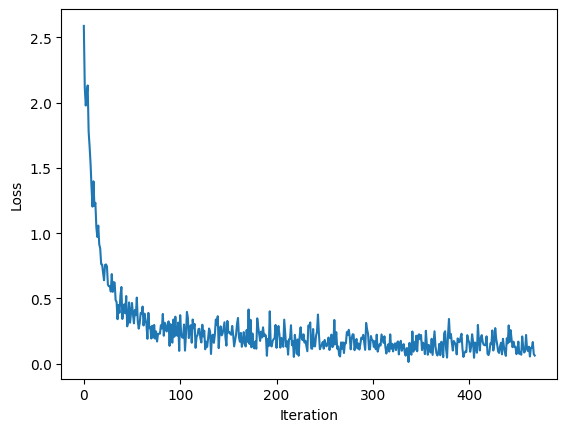

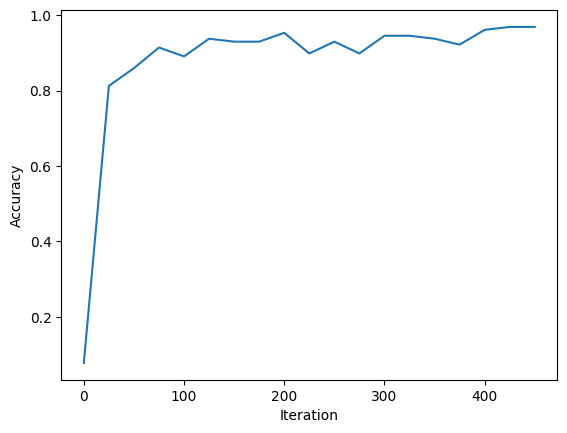

In [15]:
plt.plot(loss_hist)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

plt.plot(torch.arange(len(acc_hist)) * 25, acc_hist)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()

Let's evaluate the model on the test set:

In [16]:
@torch.no_grad()
def test_accuracy(dataloader, net):
    total = 0
    acc = 0
    
    for data, targets in iter(dataloader):
        data = data.to(device)
        targets = targets.to(device)
        
        outputs = net(data)
        
        acc += accuracy_rate(outputs, targets) * outputs.size(0)
        total += outputs.size(0)
        
    return acc / total

In [17]:
print(f"Test set accuracy: {test_accuracy(test_loader, net)*100:.3f}%")

Test set accuracy: 96.400%


Finished!